## Many with radial correlation coupling

asdf

$$
\begin{eqnarray*}
    \dot{z_i} & = & z_i \left((\lambda_i + \mathrm{i}) + b_i |z_i|^2 \right) + \sum_k W_{ik} z_k \\
    \dot{W_{ij}} & = & \alpha \left( \delta_{ij} - |z_i||z_j| \right)
\end{eqnarray*}
$$

Oops, this is broken because the weights will just decay forever.

In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

In [2]:
Nz = 20

# Hopf oscillator characteristics
l = np.random.randn( Nz )
# TODO Should the Lyopunov exponent vary across oscillators?
b = -0.1 + np.random.randn( Nz ) * 1.j

alpha = 0.1 # 0.001 # 0.1

In [3]:
def deriv( t, y ):
    
    z = y[:Nz]
    W = np.reshape( y[Nz:], (Nz, Nz) )
    
    z_dot = np.zeros( z.shape[0], dtype = np.complex )
    
    for i in range( z_dot.shape[0] ):
        z_dot[i] = z[i] * ( ( l[i] + 1.j ) + b[i] * z[i] * np.conj( z[i] ) )
        
        for k in range( z_dot.shape[0] ):
#             if k == i:
#                 continue
#             z_dot[i] += W[i, k] * np.real( z[k] )
            z_dot[i] += W[i, k] * z[k]
    
#     W_dot = alpha * ( np.eye( Nz ) - np.outer( np.real( z ), np.real( z ) ) )
#     W_dot = alpha * ( np.eye( Nz ) - np.outer( z, np.conj( z ) ) )
    W_dot = alpha * ( np.eye( Nz ) - np.outer( np.abs( z ), np.abs( z ) ) )
    
#     if t > 2000:
#         W_dot = np.zeros( W.shape, dtype = np.complex )
    
    y_dot = np.zeros( y.shape[0], dtype = np.complex )
    y_dot[:Nz] = z_dot
    y_dot[Nz:] = W_dot.flatten()
    
    return y_dot

In [4]:
t_span = [0, 2e3]
t_eval = np.arange( t_span[0], t_span[-1], 1e-2 )

In [5]:
# TODO Randomize the z0 in an intelligent way
z0 = np.zeros( (Nz,), dtype = np.complex )
for i in range( z0.shape[0] ):
    z0[i] = 0.01 + 0.j
    
W0 = np.random.randn( Nz, Nz ) # + np.random.randn( Nz, Nz ) * 1.j

In [6]:
y0 = np.zeros( (Nz + Nz*Nz,), dtype = np.complex )
y0[:Nz] = z0
y0[Nz:] = W0.flatten()

In [7]:
sol = scipy.integrate.solve_ivp( deriv, t_span, y0,
                                 t_eval = t_eval,
                                 method = 'BDF' )

In [8]:
t_star = sol.t
y_star = sol.y

z_star = y_star[:Nz, :]
W_star = np.reshape( y_star[Nz:, :], (Nz, Nz, y_star.shape[1]) )

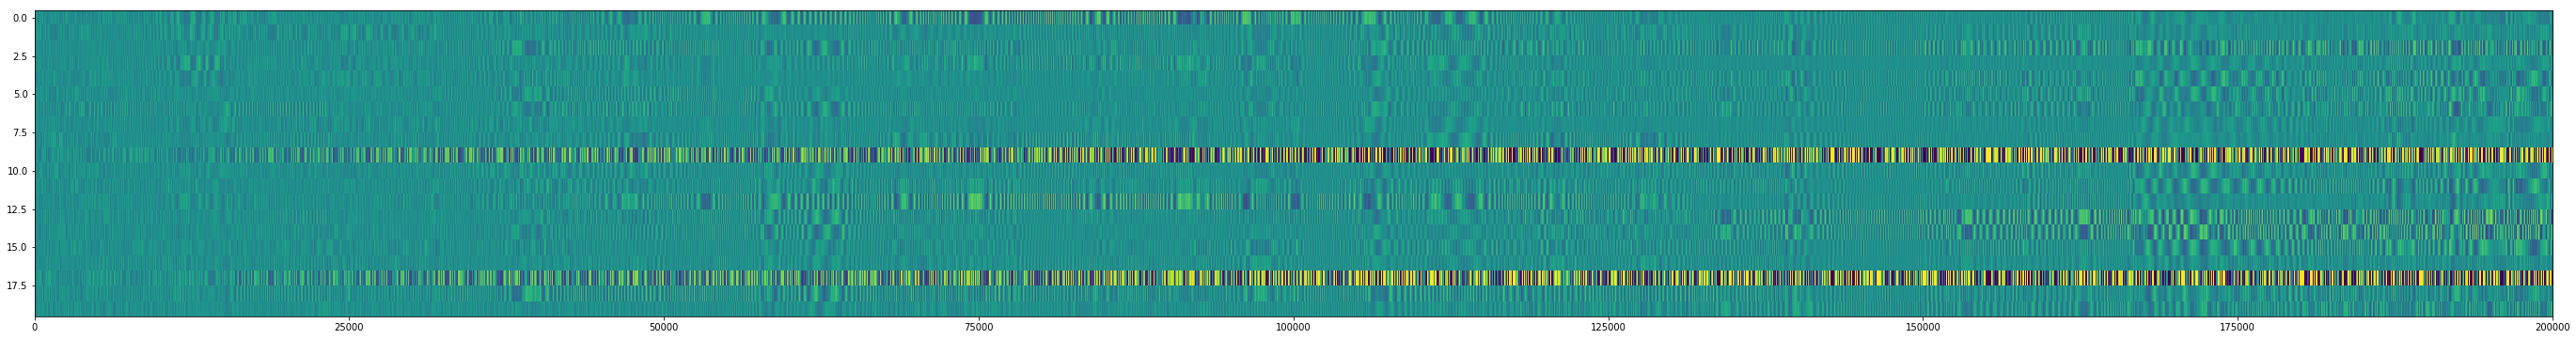

In [9]:
plt.figure( figsize = (48, 6) )
plt.imshow( np.real( z_star ), aspect = 'auto',
            vmin = np.quantile( np.real( z_star ), 0.01 ),
            vmax = np.quantile( np.real( z_star ), 0.99 ) )

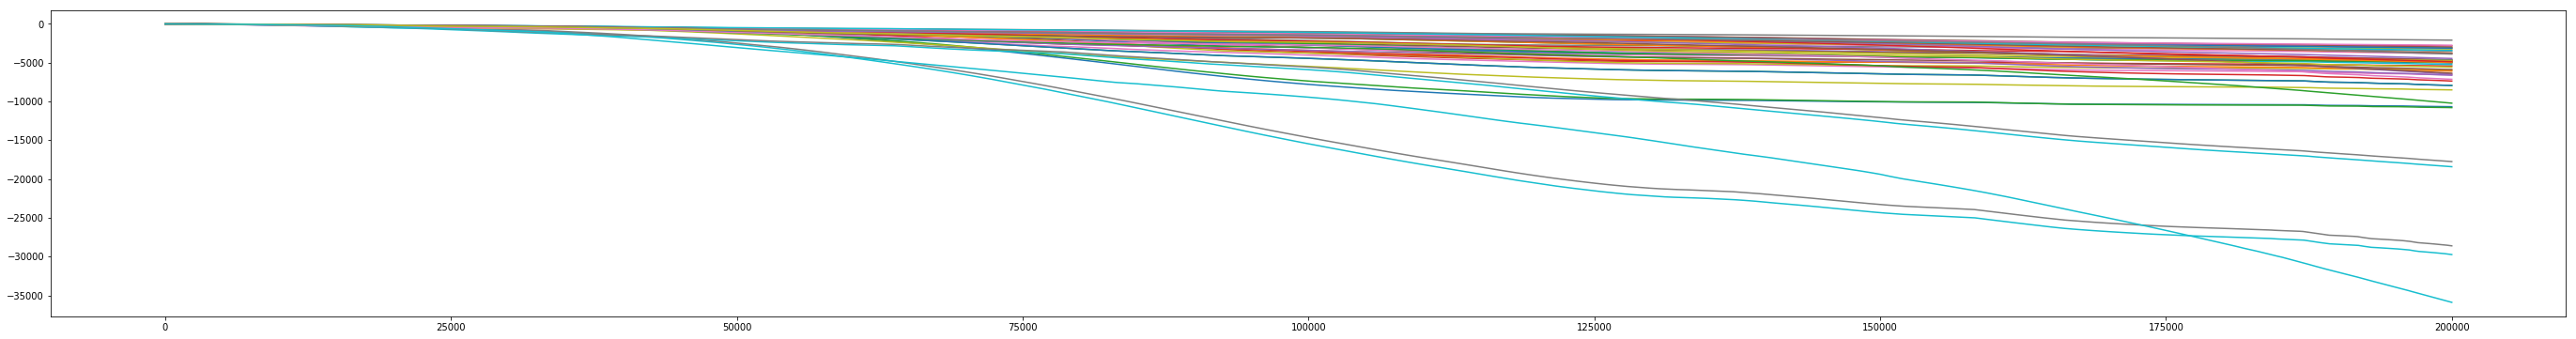

In [18]:
plt.figure( figsize = (48, 6) )
plt.plot( np.real( y_star[(Nz):(Nz+50), :] ).T )
plt.show()

In [10]:
import scipy.signal
import concurrent.futures
import time

In [11]:
coherence_window = 512
coherence_window_step = 128
coherence_nfft = 512
coherence_f_min = 0.0
coherence_f_max = 0.1

coherence_starts = np.arange( 0, z_star.shape[1] - coherence_window, coherence_window_step )

def coherence_procedure( i ):
    
    start = time.time()
    
    print( 'Starting row {0}'.format( i ) )
    
    ret = np.zeros( (Nz, coherence_starts.shape[0]) )
    
    for j in range( Nz ):
        for i_start, cur_start in enumerate( coherence_starts ):
            cur_end = cur_start + coherence_window
            cur_data_i = np.real( z_star[i, cur_start:cur_end] )
            cur_data_j = np.real( z_star[j, cur_start:cur_end] )

            f, Cxy = scipy.signal.coherence( cur_data_i, cur_data_j, nfft = coherence_nfft )
            ret[j, i_start] = np.mean( Cxy[(f >= coherence_f_min) & (f < coherence_f_max)] )
    
    end = time.time()
    time_delta = end - start
    
    return ret, time_delta

In [12]:
run_outputs = []
run_times = []

start = time.time()
with concurrent.futures.ProcessPoolExecutor() as executor:
    for cur_output, cur_time in executor.map( coherence_procedure, range( Nz ) ):
        run_outputs.append( cur_output )
        run_times.append( cur_time )
end = time.time()

print( 'Done.' )

Starting row 0
Starting row 2
Starting row 1
Starting row 3
Starting row 4
Starting row 5
Starting row 6
Starting row 7
Starting row 8
Starting row 9
Starting row 10
Starting row 11
Starting row 12
Starting row 13
Starting row 14
Starting row 15
Starting row 16
Starting row 17
Starting row 18
Starting row 19
Done.


In [13]:
print( 'Total execution time: {0:0.3f}'.format( sum( run_times ) ) )
print( 'Total wall time: {0:0.3f}'.format( end - start ) )
print( 'Time saved: {0:0.3f}'.format( sum( run_times ) - (end - start) ) )

Total execution time: 549.591
Total wall time: 137.885
Time saved: 411.706


In [14]:
coherence_traces = np.zeros( (Nz, Nz, coherence_starts.shape[0],) )
for i in range( Nz ):
    coherence_traces[i, :, :] = run_outputs[i]

In [15]:
coherence_centers = coherence_starts + coherence_window / 2

In [16]:
coherence_traces_list = []
coherence_pair_list = []
for i in range( Nz ):
    for j in range( i+1, Nz ):
        coherence_traces_list.append( coherence_traces[i, j, :] )
        coherence_pair_list.append( (i, j) )

coherence_traces_linear = np.zeros( (len( coherence_traces_list ), coherence_traces_list[0].shape[0]) )
for i, trace in enumerate( coherence_traces_list ):
    coherence_traces_linear[i, :] = trace

NameError: name 't_input_start' is not defined

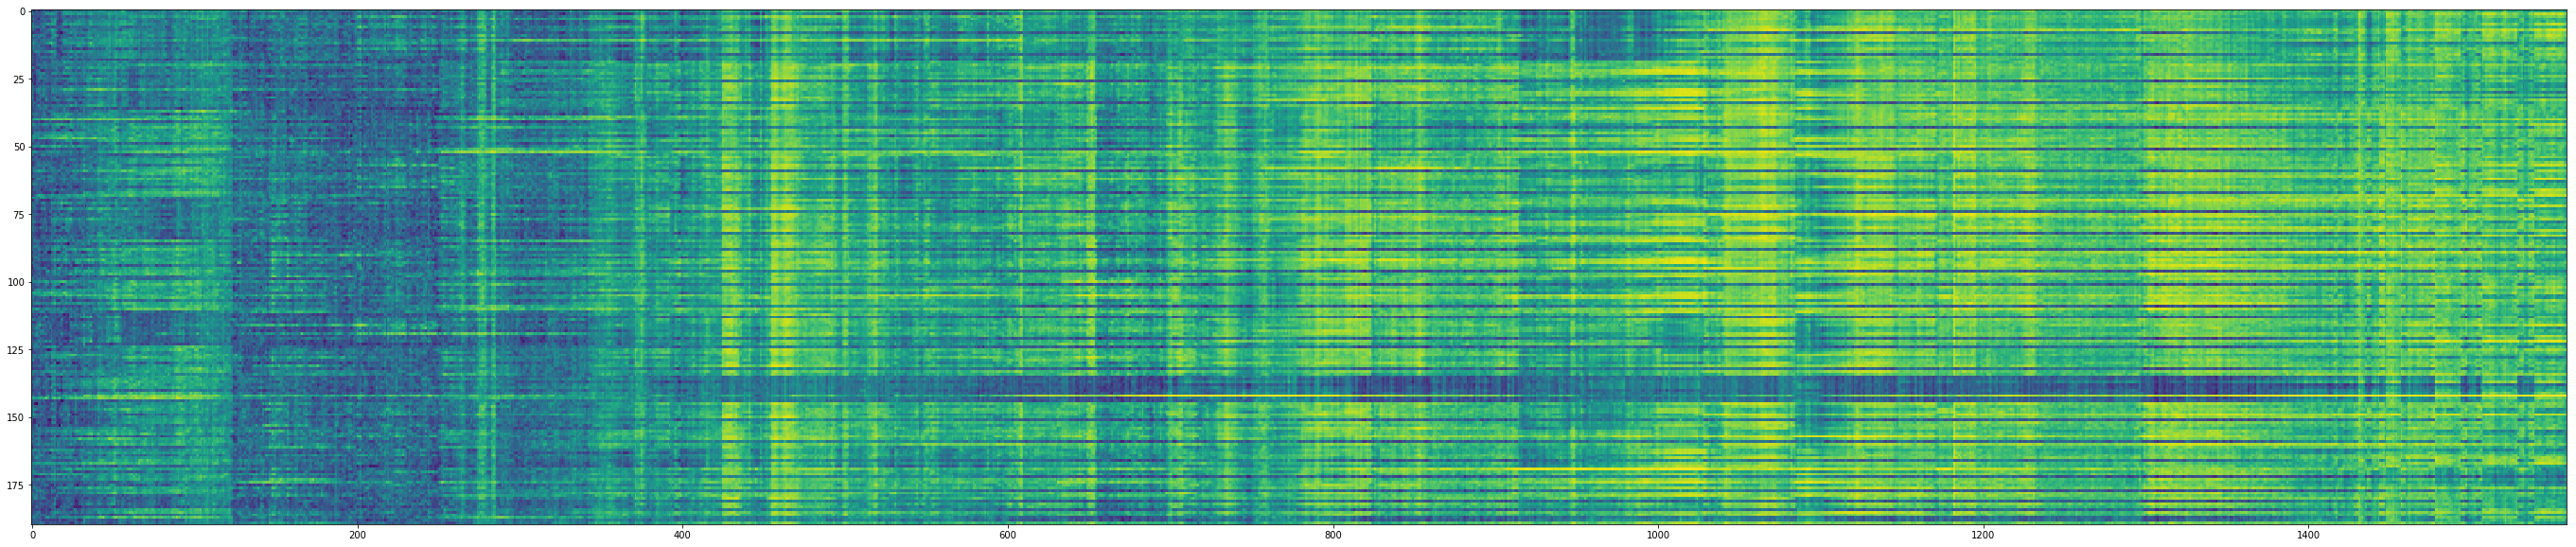

In [17]:
# i_coherence_trunc = np.where( (coherence_centers / 1e2) >= 2000 )[0][0]

plt.figure( figsize = (48, 10) )
plt.imshow( coherence_traces_linear, aspect = 'auto' )

sample_start = np.min( np.where( (coherence_centers / 100) >= t_input_start )[0] )
sample_end = np.max( np.where( (coherence_centers / 100) < t_input_end )[0] )
yl = plt.ylim()
plt.plot( sample_start * np.array( [1, 1] ), yl, 'w--' )
plt.plot( sample_end * np.array( [1, 1] ), yl, 'w--' )

plt.clim( 0, 1 )